<hr style="border-width:4px; border-style:solid; border-color:coral"/>

# Data Assimilation using the  representer method
<hr style="border-width:4px; border-style:solid; border-color:coral"/>


The notebook solves the scalar advection equation, given by the partial differential equation

\begin{equation}
q_t + u q_x = 0
\end{equation}

where $u$ is a prescribed velocity field.  This equation models, for example, the transport of a tracer field in a background flow.  

We solve this problem in the periodic domain $x \in [0,1]$ over the time interval $t \in [0,T_{final}]$.  We set the velocity field to $u=1$. 

Observed data values are assimilated into the calculation to improve the model to more accurately predict the observed values.

In this notebook, we use exact solutions for the representers, so don't require any numerical integration.  

In [1]:
%matplotlib notebook
%pylab
%reload_ext autoreload
%autoreload 2
from scipy.stats import chi2

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


<hr style="border-width:4px; border-style:solid; border-color:coral"/>

## Problem parameters

In [3]:
# Domain [ax,bx]
ax = 0
bx = 1

# Velocity (constant in this example)
u = 1
u = -1 # for case 2

# Final time
T_final = 1.0

# Boundary conditions

bc_choice = 'dirichlet'  # 'zero','periodic', 'dirichlet', 'noflux'

# Concentration profile used for initial conditions and exact solution.
def concentration(x):
    r = abs(x-0.25)
    r0 = 0.25
    return where(r < r0,exp(-160*r**2),0)

def bc_zerobc(q):
    q_ext = concatenate(([0,0], q,[0,0]))
    return q_ext


def bc_zerobc(q):
    q_ext = concatenate(([0,0], q,[0,0]))
    return q_ext


def bc_periodic(q):
    q_ext = concatenate((q[-2:], q,q[:2]))
    return q_ext


def bc_dirichlet(q):
    # Include two extra layers of cells on either side of q.  
    # Example : If q is (mx) x (1), then q_ext should be (mx+4) x 1
    
    if (u > 0):
        # Nothing comes in from the left;  allow flow out at the right
        q_ext = concatenate(([0,0], q,[q[-1]]*2))
    else:
        # Nothing comes in from the right;  allow flow out at the left
        q_ext = concatenate(([q[0]]*2, q,[0,0]))
    return q_ext

def bc_noflux(q):
    if (u > 0):
        # Match value at left and right
        q_ext = concatenate(([q[0]]*2, q,[q[-1]]*2))
    else:
        # Match value at left and right
        q_ext = concatenate(([q[0]]*2, q,[q[-1]]*2))
    return q_ext

### Numerical parameters

User defined parameters needed for numerical evaluation. 

In [4]:
# Number of grid points on cell centered mesh
mx = 256

# CFL number, 0 < CFL < 1.  Closer to 1 is better.
CFL = 0.9

### Weights for the model, initial conditions and boundary conditions
The functions defined below depend on the values, and other values, so everything is kept in the same cell. 

In [5]:
from wpa import *

# weights for the model and so on.
# Cf = 100.0     # Model weights
# Ci =  0.01   # Initial conditions
# Cb = 0.01      # boundary conditions

Cf = 0.1    # Model weights
Ci = 0.1   # Initial conditions
Cb = 10.0    # boundary conditions

# Sharpness of the delta function (1e-3 = not very sharp; 1e-5 = sharp)
eps = 1e-3

# User specificed limiter : 'minmod','superbee','vanleer','minmod'
# Use None for no limiting
limiter_choice = 'MC'

elif bc_choice == 'dirichlet':
    bc_func = bc_dirichlet
elif bc_choice == 'noflux':
    bc_func = bc_noflux
elif bc_choice == 'zerobc':
    bc_func = bc_zerobc
# Initial condition for unforced solution u_F
def initial_condition(x):
    return concentration(x)

# Exact solution to unforced problem.
def qexact(x,t):
    return concentration(x-u*t)

# Discrete delta function
def delta(x):
    return exp(-x**2/(4*eps))/sqrt(4*pi*e)

# Use Duhamel's Principle to compute the solution to the adjoint alpha_m and 
# representer r_m
def adjoint_exact(x,t,xm,tm):
    return where(t < tm,delta(x-xm - u*(t-tm)),0)  # Sub in x-xm, t - tm

def representer_exact(x,t,xm,tm):
    a0 = adjoint_exact(x-u*t,0,xm,tm)  # Initial condition
    return Ci*a0 + Cf*delta(x-xm-u*(t-tm))*where(t < tm, t,tm)

def Q_forcing():
    q0 = initial_condition(xc)
    
    mx = len(xc)
    M = len(tv) - 1
    
    F = zeros((mx,M+1)) #zero forcing!
    Q = evolve_q(mx,ax,bx,dt,dx,q0, F, bc_func, tv, lim_choice=limiter_choice, uvel=u)
    return Q
    
# Return matrix
def adjoint(xm,tm):

    # Initial conditions = 0   
    mx = len(xc)
    M = len(tv) - 1

    q0 = zeros(xc.shape)
    
    # Forcing term
    F = zeros((mx,M+1))
    for n in range(0,M+1):
        tau = tv[n]
        F[:,n] = delta(xc-xm)*delta(T_final-tm-tau)

    # Get alpha_tilde(x,tau) = alpha(x,T-final-t)
    Q = evolve_q(mx,ax,bx,dt,dx, q0, F, bc_func, tv, lim_choice=limiter_choice,uvel = -u)
    
    adjoint = zeros((mx,M+1))
    for n in range(0,M+1):
        adjoint[:,n] = Q[:,M-n]
            
    return adjoint

def representer(xm,tm):
    
    alpha = adjoint(xm,tm)
    
    M = len(tv) -1
    mx = len(xc)
    
    F = zeros((mx,M+1))
    for n in range(0,M+1):
        t = tv[n]
        F[:,n] = Cf*where(t <= tm, alpha[:,n],0)
    
    q0 = Ci*alpha[:,0]
    Rm = evolve_q(mx,ax,bx,dt,dx,q0,F,bc_func, tv,lim_choice=limiter_choice,uvel=u)

    return Rm

def interpolate(Q,xm,tm):
    
    # Interpolate Q values in a matrix to (xm,tm) 
    mlow = int(floor(tm/dt))
    tlow = tv[mlow]
    ft = (tm-tlow)/dt
    
    jlow = int(floor((xm-ax)/dx))-1
    xlow = xc[jlow]
    fx = (xm-xlow)/dx    
    
    qlow_t = Q[:,mlow]
    qvec = qlow_t + ft*(Q[:,mlow+1] - Q[:,mlow])

    qlow_x = qvec[jlow]
    qval = qlow_x + fx*(qvec[jlow+1] - qvec[jlow])

    return qval

<hr style="border-width:4px; border-style:solid; border-color:coral"/>

## Measurements and weights
We create obseverable data triples (xm,tm,dm,winv) using a random number generator. The data values are taken to be perturbations to an exactly defined solution for the unforced scalar advection problem.

In [6]:
seed(1)
# Number of observables
mdata = 6

# Spatial location of data points : in [ax,bx] (uniform random locations)
#xm_data = ax + (bx-ax)*random.rand(mdata)

xm_data = ax + (bx-ax)*random.rand(mdata)

# Time of data points :  in [0,T] (uniform random time values)

# Measurements all taken at the same time.
tm_data = T_final*array([random.rand()]*mdata)    

# Choose different times for each measurement
#tm_data = T_final*random.rand(mdata) 
print(tm_data)

[0.18626021 0.18626021 0.18626021 0.18626021 0.18626021 0.18626021]


Construct measured values, based on noise.

In [7]:
# Noise in the data : wnoise*randn() 
wnoise = 0.25

# Measurements : Normally distributed perturbations to "perfect" data
dm_data = empty(mdata)
for j in range(0,mdata):
    dm_data[j] = concentration(xm_data[j]-u*tm_data[j]) + abs(wnoise*random.randn())
print(dm_data)

[1.21898564 0.41362886 0.59086715 0.34054332 0.25425353 0.15934045]


Supply data weights for each data point. Trusted data is given a large weight (small inverse) and untrusted data is given a small weight (large inverse). 

In [8]:
# Weights on data ("w")   (??)
wminv = 0.01*ones(mdata)     # Default : Assume data is perfect


Create list of data tuples

In [9]:
# Create list of tuples
data = list(zip(xm_data,tm_data,dm_data,wminv))    
print(data)

[(0.417022004702574, 0.1862602113776709, 1.2189856391955367, 0.01), (0.7203244934421581, 0.1862602113776709, 0.4136288631016423, 0.01), (0.00011437481734488664, 0.1862602113776709, 0.590867151195003, 0.01), (0.30233257263183977, 0.1862602113776709, 0.3405433160996637, 0.01), (0.14675589081711304, 0.1862602113776709, 0.25425353411675516, 0.01), (0.0923385947687978, 0.1862602113776709, 0.1593404535153311, 0.01)]


<hr style="border-width:4px; border-style:solid; border-color:coral"/>

## Set up numerical mesh

Define the spatial cell-centered mesh and time step size, and number of time steps.

In [11]:
# Spatial step
dx = (bx-ax)/mx

# Generate spatial meshes
xe = linspace(ax,bx,mx+1)
xc = xe[:-1] + dx/2

# Time step
dt_est = CFL*dx/u
M = int(T_final/dt_est) + 1
dt = T_final/M

# Temporal mesh
tv = linspace(0,T_final,M+1)

<hr style="border-width:4px; border-style:solid; border-color:coral"/>

## Compute representers and inverse solution $\widehat{u}(x,t)$

The representers are computed using numerical integration.

In [12]:
R = zeros((mdata,mdata))
h = zeros(mdata)

rmd = []
# Compute R using exact solution
for j,dj in enumerate(data):
    # dj = data[j]
    xm = dj[0]
    tm = dj[1]
    dm = dj[2]
    Rm = representer(xm,tm)
    rmd.append(Rm)
    # Compute lower triangular portion;  enforce symmtry
    for i,d in enumerate(data):
        if i < j:
            # continue
            pass
        R[i,j] = interpolate(Rm,d[0],d[1])     
        # R[j,i] = R[i,j]  # enforce symmetry
        
    # Use exact solution to get Uf entries
    uf = qexact(xm,tm)    
    
    # Construct right hand side    
    h[j] = dm - uf

# Create matrix of weights.  Use diagonal weighting
wm = [w[3] for w in data]
W_inv = diag(wm)
    
# Solve for beta values
P = R + W_inv
beta = linalg.solve(P,h)

# Get forcing
UF = Q_forcing()

Uhat = UF
for j,d in enumerate(data):       
    # rmd = representer(d[0],d[1])    
    Uhat += beta[j]*rmd[j]


# print("\nx  : ")
# print(xm)
# print("\nt : ")
# print(tm)
# print("\ndata : ")
# print(dm)   
    
print(UF)    
    
print("Done computing Uhat")

print("\nR matrix : ")
f = {'all' : lambda x : "{:10.4f}".format(x)}
with np.printoptions(precision=6, suppress=True, formatter=f,linewidth=100):
    print(R)
    
print("\nbeta vector:")
f = {'all' : lambda x : "{:12.4e}".format(x)}
with np.printoptions(precision=6, suppress=True, formatter=f,linewidth=100):
    print(beta)    
print("\n$\hat{U_F}$ vector:")


[[ 7.58064142e-003  7.84175999e-004  3.51727023e-005 ...  3.21915138e-217
  -6.15879006e-217 -2.97707547e-217]
 [ 7.38178694e-003  7.60777801e-003  1.56323244e-003 ...  1.48370956e-215
   3.91130651e-216 -1.31221124e-216]
 [ 7.22515399e-003  7.38940796e-003  7.63287223e-003 ... -1.68708779e-215
   3.37555108e-215  1.61738961e-215]
 ...
 [ 5.58245877e-011  5.60224366e-011  5.62221465e-011 ...  3.98623055e-003
   2.55979476e-003  1.52445578e-003]
 [ 5.58236136e-011  5.60203136e-011  5.62180108e-011 ...  5.58896893e-003
   4.15626261e-003  2.71019520e-003]
 [ 5.58233144e-011  5.60194271e-011  5.62160245e-011 ...  6.85803999e-003
   5.78372363e-003  4.39553103e-003]]
Done computing Uhat

R matrix : 
[[    0.0003     0.0000     0.0000     0.0001     0.0000     0.0000]
 [    0.0000     0.0003     0.0000     0.0000     0.0000     0.0000]
 [   -0.0000     0.0000    -0.0001    -0.0000    -0.0000    -0.0001]
 [    0.0000     0.0000     0.0000     0.0003     0.0000     0.0000]
 [    0.0000     0.

In [13]:
W = diag(1/wminv)
#print(W)

<hr style="border-width:4px; border-style:solid; border-color:coral"/>

## Plot the inverse $\widehat{u}(x,t)$
Plot the least squares solution (the inverse "uhat").   Along with the solution, we also plot the data points and show that the data points are approximately interpolated, depending on how the weights are set. 

In [14]:


 q1 = Uhat[:,0]
# q1[0]=0
# q1[-1]=0
q1.shape
#Uhat[:,0]
#xm_data

(256,)

In [15]:
np.where(q1 == 0.27648377)

(array([], dtype=int64),)

In [16]:
S = zeros(mdata)
for j,d in enumerate(data):
    
    sd = where(xc <= d[0])
    
    if(len(sd[0]) == 0):
        S[j] = 0
    else:
        S[j] = sd[0][-1]


<IPython.core.display.Javascript object>


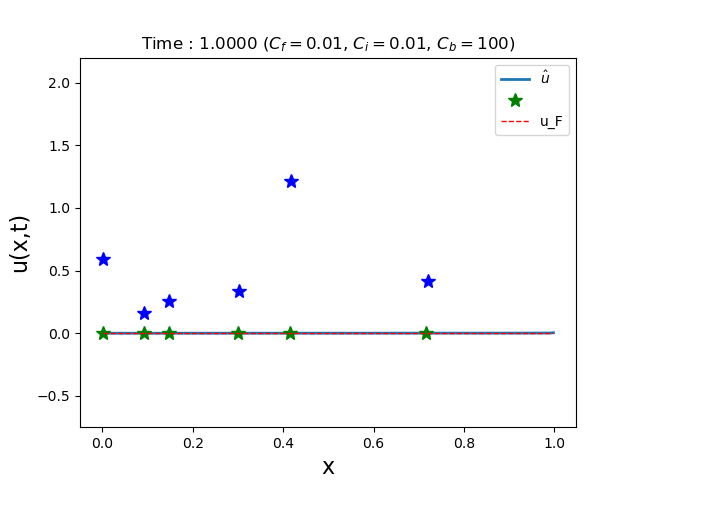

In [17]:
q = Uhat[:,0]
xx = [xc[int(j)] for j in S]
qx = [q[int(j)] for j in S]

fig = figure(3)
clf()

# Evaluate initial conditions
q = Uhat[:,0]

# Plot initial solution and store handle
hdl, = plot(xc,q,linewidth=2,label='Computed solution')
hdl2, = plot(xx,qx,'g*',markersize=10)
htitle = title('Time : {:.4f} (xm,tm,dm,wminv)'.format(0))

t = 0
d = initial_condition(xc)
hdl_exact, = plot(xc,d,'r--',linewidth=1,label='U_F')

xlabel('x',fontsize=16)
ylabel('u(x,t)', fontsize=16)

hdl_data = [None]*mdata
for j,d in enumerate(data):
    xm = d[0]
    tm = d[1]
    dm = d[2]
    wm = d[3]
    str = '({:.2f},{:.2f},{:.2f},{:.2f})'.format(xm,tm,dm,wm)
    hdl_data[j], = plot(xm,dm,'#888888',marker='*',markersize=10, \
                       label=str)

ylim([-0.75,2.2])

fig.canvas.draw()   

hit_data = zeros(mdata)
pause(0.5)
for n in range(0,M+1):  
    
    t = tv[n]
    q = Uhat[:,n]
    hdl.set_ydata(q)
    qx = [q[int(j)] for j in S]
    hdl2.set_ydata(qx)
    # Update title with new time
    htitle.set_text('Time : {:.4f} ($C_f=0.01$, $C_i=0.01$, $C_b=100$)'.format(t))
    
    # Plot unforced solution u_F
    d = qexact(xc, t)
    # d = UF[:,n]
    hdl_exact.set_ydata(d)

    # Change the color of any data points we hit 
    for j,d in enumerate(data):
        tm = d[1]
        if (tm <= t and t < tm + dt):
            hdl_data[j].set_color('r')
            hit_data[j] = 1
            qxrd = qx
        elif hit_data[j] == 1:
            hdl_data[j].set_color('b')
            hit_data[j] = 2

    ylim([-0.75,2.2])

    # Add legend; refresh plot
    #legend(loc='upper center',ncol=2)
    legend(['$\hat{u}$','','u_F'])
    fig.canvas.draw()        
    
    if any(hit_data == 1):
        # Pause when solution hits a data point
        pause(2)
        

In [18]:
qxrd

[0.924751369020258,
 0.010875611913483126,
 3.106792057887515e-05,
 0.05114771224697374,
 0.0012192248227672195,
 0.0008838705815370973]

In [19]:

qxrd[0]
xm_data
d1 = reshape(dm_data, (mdata, 1))
d2 = array([[qxrd[0]],[qxrd[1]],[qxrd[2]],[qxrd[3]],[qxrd[4]],[qxrd[5]]])
d21 = array([qxrd]).T
obs = linalg.norm(d21 - d1)
print(obs)
print(1-chi2.cdf(obs,5))


0.8779270643233847
0.9717990119212957


### Statistic

In [20]:
# From Bennet, page 22 (Exercise 1.3.3 and 1.3.4)
print("From Bennet, page 23")
JuF = h.transpose()@W@h
print("J[uF] = {:.4e}".format(JuF))

Juhat = h.transpose()@beta
print("J[uhat] = {:.4e}".format(Juhat))

Jdata = beta.transpose()@W_inv@beta
print("Jdata = {:.4e}".format(Jdata))

Jmod = Juhat - Jdata
print("Jmodel = {:.8e}".format(Jmod))

print("\nFrom Bennet, page 44")
T = sqrt(W)@R@sqrt(W)
print("EJF = {:.8e}".format(trace(T) + mdata))

# From Bennet, page 44 (Exercise 2.3.2)
Pinv = inv(P)
T = sqrt(W_inv)@Pinv@sqrt(W_inv)
print("EJdata = {:.8e}".format(trace(T)))

From Bennet, page 23
J[uF] = 7.6725e+01
J[uhat] = 7.6207e+01
Jdata = 7.5723e+01
Jmodel = 4.83583106e-01

From Bennet, page 44
EJF = 6.07523320e+00
EJdata = 5.92711294e+00
